In [0]:
from scipy.io import mmread
import pandas as pd
import numpy as np
import random
import math
import scipy
import matplotlib.pyplot as plt

In [143]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [162]:
k562 = pd.read_csv('drive/My Drive/COMS4995_Final/FullSC/k562_full.csv', sep = ',', names = ("GeneID", "3+ UTR", "5+ UTR", "Distal Intergenic", "Downstream (1-2kb)", "Downstream (2-3kb)", "Downstream (<=1kb)", "Exon", "Intron", "Promoter (1-2kb)", "Promoter (2-3kb)", "Promoter (<=1kb)")).values
gm = pd.read_csv('drive/My Drive/COMS4995_Final/FullSC/gm_full.csv', sep = ',', names = ("GeneID", "3+ UTR", "5+ UTR", "Distal Intergenic", "Downstream (1-2kb)", "Downstream (2-3kb)", "Downstream (<=1kb)", "Exon", "Intron", "Promoter (1-2kb)", "Promoter (2-3kb)", "Promoter (<=1kb)")).values
print(list(np.sum(gm[:,1:], axis=0)/gm.shape[0]))
print(gm.shape[0])
print(np.count_nonzero(gm) / 11593)

[0.08909871244635194, 0.032188841201716736, 2.248068669527897, 0.015793991416309012, 0.014592274678111588, 0.019914163090128754, 0.19141630901287554, 2.2503862660944205, 0.20695278969957082, 0.18214592274678112, 0.9455793991416309]
11650
3.451565599930993


11
11


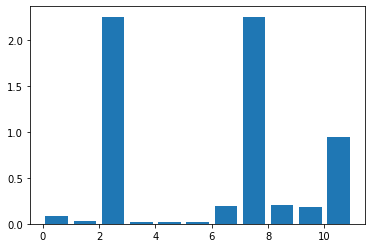

In [174]:
heights = list(np.sum(gm[:,1:], axis=0)/gm.shape[0])
pos = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5]
print(len(heights))
print(len(pos))
plt.bar(pos, heights)
plt.show()

In [164]:
gm_train = pd.read_csv('drive/My Drive/COMS4995_Final/deepdiff/data/ProcessedData/E123.train.csv', sep = ',', names = ("1", "2", "3", "4", "5")).values
gm_test = pd.read_csv('drive/My Drive/COMS4995_Final/deepdiff/data/ProcessedData/E123.test.csv', sep = ',', names = ("1", "2", "3", "4", "5")).values
gm_valid = pd.read_csv('drive/My Drive/COMS4995_Final/deepdiff/data/ProcessedData/E123.valid.csv', sep = ',', names = ("1", "2", "3", "4", "5")).values
print((gm_train.shape[0] + gm_valid.shape[0] + gm_test.shape[0])/200)
print((np.sum(gm_train, axis=0) + np.sum(gm_valid, axis=0) + np.sum(gm_test, axis=0))/(gm_train.shape[0] + gm_valid.shape[0] + gm_test.shape[0]))
print((np.count_nonzero(gm_train) + np.count_nonzero(gm_valid) + np.count_nonzero(gm_test)) / (gm_train.shape[0] + gm_valid.shape[0] + gm_test.shape[0]))

18460.0
[2.62778413 3.88868635 1.48399702 1.55557367 1.45061403]
3.1757741061755147


Stats:

k562 bulk: 11593 genes, avg count per region per gene: 
[0.01, 0.03, 1.89, 0.02, 0.01, 0.02, 0.21, 2.01, 0.16, 0.14, 0.27]
, avg 2.96 non-zero entries per row

gm bulk: 11593 genes, avg count per region per gene:
[0.09, 0.03, 2.24, 0.02, 0.01, 0.02, 0.19, 2.25, 0.21, 0.18, 0.95]
, avg 3.43 non-zero entries per row

---

k562 sc: 11650 genes, avg count per region per gene:
[0.10, 0.02, 1.87, 0.02, 0.01, 0.02, 0.19, 1.97, 0.16, 0.15, 0.26]
, avg 2.96 non-zero entries per row

gm sc: 11650 genes, avg count per region per gene: 
[0.09, 0.03, 2.24, 0.02, 0.02, 0.02, 0.19, 2.25, 0.21, 0.18, 0.95]
, avg 3.45 non-zero entries per row

---

k562 deepdiff: 18460 genes, avg count per HM per gene per bin (200 bins per gene)
[2.80, 3.46, 1.39, 1.07, 1.65]
, avg 2.95 non-zero entries per row

gm deepdiff: 18460 genes, avg count per HM per gene per bin (200 bins per gene)
[2.63, 3.89, 1.48, 1.56, 1.45]
, avg 3.18 non-zero entries per row


In [0]:
def getlabel(c1,c2):
	# get log fold change of expression

	label1=math.log((float(c1)+1.0),2)
	label2=math.log((float(c2)+1.0),2)
	label=[]
	label.append(label1)
	label.append(label2)

	fold_change=(float(c2)+1.0)/(float(c1)+1.0)
	log_fold_change=math.log((fold_change),2)
	return (log_fold_change, label)

def loadDict(filename):
	# get expression value of each gene from cell*.expr.csv
	gene_dict={}
	with open(filename) as fi:
		for line in fi:
			geneID,geneExpr=line.split(',')
			gene_dict[str(geneID)]=float(geneExpr)
	fi.close()
	return(gene_dict)

In [0]:
k562_exp = loadDict('drive/My Drive/COMS4995_Final/FullSC/k562_full.expr.csv')
gm_exp = loadDict('drive/My Drive/COMS4995_Final/FullSC/gm_full.expr.csv')

In [0]:
X = np.empty((0,22), int)
y = np.empty((0), float)
for i in range(len(gm)):
  gene = gm[i,0]
  full_input = np.expand_dims(np.concatenate((gm[i,1:], k562[i,1:])), 0)
  X=np.append(X, full_input, axis=0)
  y=np.append(y, np.expand_dims(getlabel(gm_exp[gene], k562_exp[gene])[0], 0), axis=0)

cutoff = math.floor(len(X)*0.7)
trainX = np.array(X[:cutoff])
testX = np.array(X[cutoff:])
trainy = np.array(y[:cutoff])
testy = np.array(y[cutoff:])

In [122]:
from sklearn import svm
clf = svm.SVR()
clf.fit(trainX, trainy)
test_predictions = clf.predict(testX)
R2,p=scipy.stats.pearsonr(test_predictions,testy)
print(R2)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.25054363621392295


In [123]:
kX = np.empty((0,11), int)
ky = np.empty((0), float)
gX= np.empty((0,11), int)
gy = np.empty((0), float)

for i in range(len(gm)):
  gene = gm[i,0]
  kX = np.append(kX, np.expand_dims(k562[i,1:], 0), axis=0)
  gX = np.append(kX, np.expand_dims(gm[i,1:], 0), axis=0)
  ky = np.append(ky, np.expand_dims(k562_exp[gene], 0), axis=0)
  gy = np.append(gy, np.expand_dims(gm_exp[gene], 0), axis=0)

cutoff = math.floor(len(X)*0.7)
kclf = svm.SVR()
kclf.fit(kX[:cutoff], ky[:cutoff])
gclf = svm.SVR()
gclf.fit(gX[:cutoff], gy[:cutoff])

predictions = []
targets = []
kpreds = kclf.predict(kX)
gpreds = gclf.predict(gX)
for i in range(cutoff, len(gm)):
  predictions.append(getlabel(kpreds[i], gpreds[i])[0])
  targets.append(getlabel(ky[i], gy[i])[0])
R2,p=scipy.stats.pearsonr(predictions,targets)
print(R2)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.0774353452632155


Baseline accuracies:

Bulk joint: 0.2755

Bulk separate: 0.0905

Single joint: 0.2505

Single separate: 0.0774